In [ ]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 2D Latent Diffusion Model

In this tutorial, we will walk through the process of using the MONAI Generative Models package to generate synthetic data using Latent Diffusion Models (LDM)  [1, 2]. Specifically, we will focus on training an LDM to create synthetic X-ray images of hands from the MEDNIST dataset.

[1] - Rombach et al. "High-Resolution Image Synthesis with Latent Diffusion Models" https://arxiv.org/abs/2112.10752

[2] - Pinaya et al. "Brain imaging generation with latent diffusion models" https://arxiv.org/abs/2209.07162


### Set up environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

### Setup imports

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from generative.inferers import LatentDiffusionInferer
from generative.losses.adversarial_loss import PatchAdversarialLoss
from generative.losses.perceptual import PerceptualLoss
from generative.networks.nets import AutoencoderKL, DiffusionModelUNet, PatchDiscriminator
from generative.networks.schedulers import DDPMScheduler

print_config()

/media/walter/Storage/Projects/GenerativeModels/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2023-03-16 19:58:38,469 - A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'
MONAI version: 1.2.dev2304
Numpy version: 1.23.5
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 9a57be5aab9f2c2a134768c0c146399150e247a0
MONAI __file__: /media/walter/Storage/Projects/GenerativeModels/venv/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
ITK version: 5.3.0
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.3.0
Tensorboard version: 2.11.0
gdown version: 4.6.0
TorchVision version: 0.14.1+cu117
tqdm version: 4.64.1
lmdb version: 1.4.0
psutil version: 5.9.4
pandas version: 1.5.3
einops version: 0.6.0
transformers version: 4.21.3
mlflow version: 2.1.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.

### Set deterministic training for reproducibility

In [3]:
set_determinism(42)

### Setup a data directory and download dataset
Specify a MONAI_DATA_DIRECTORY variable, where the data will be downloaded. If not specified a temporary directory will be used.

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp2pswnk7b


## Prepare training set data loader

Here we will download the MEDNIST dataset and prepare the training set data loader. The MEDNIST dataset contains images of different body parts, including the hand, chest, and abdomen, in grayscale format. For this tutorial, we will use only the `Hand` class. We include data augmentation performed by the `RandAffine` transformation in the data transformations.

In [5]:
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, seed=0)
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "Hand"]
image_size = 64
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            spatial_size=[image_size, image_size],
            padding_mode="zeros",
            prob=0.5,
        ),
    ]
)
train_ds = Dataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)

MedNIST.tar.gz: 59.0MB [00:03, 15.5MB/s]                                                                                                                                                                                       

2023-03-16 19:58:42,503 - INFO - Downloaded: /tmp/tmp2pswnk7b/MedNIST.tar.gz


2023-03-16 19:58:42,577 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2023-03-16 19:58:42,577 - INFO - Writing into directory: /tmp/tmp2pswnk7b.


Loading dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47164/47164 [00:14<00:00, 3270.92it/s]


### Visualise examples from the training set

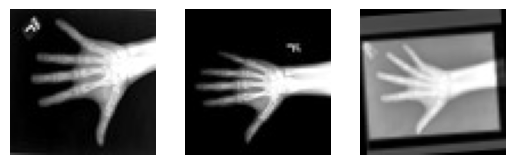

In [6]:
# Plot 3 examples from the training set
check_data = first(train_loader)
fig, ax = plt.subplots(nrows=1, ncols=3)
for image_n in range(3):
    ax[image_n].imshow(check_data["image"][image_n, 0, :, :], cmap="gray")
    ax[image_n].axis("off")

## Prepare validation set data loader

In [7]:
val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, seed=0)
val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == "Hand"]
val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)
val_ds = Dataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)

2023-03-16 19:59:01,645 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2023-03-16 19:59:01,646 - INFO - File exists: /tmp/tmp2pswnk7b/MedNIST.tar.gz, skipped downloading.
2023-03-16 19:59:01,647 - INFO - Non-empty folder exists in /tmp/tmp2pswnk7b/MedNIST, skipped extracting.


Loading dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5895/5895 [00:01<00:00, 3340.67it/s]


## Autoencoder KL

### Define Autoencoder KL network, losses and optimiser

In this section, we will define an autoencoder with KL-regularization for the LDM. The autoencoder's primary purpose is to transform input images into a latent representation that the diffusion model will subsequently learn. By doing so, we can decrease the computational resources required to train the diffusion component, making this approach suitable for learning high-resolution medical images. We will also specify the perceptual and adversarial losses, including the involved networks, and the optimizers to use during the training process.

In [8]:
device = torch.device("cuda")

autoencoderkl = AutoencoderKL(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(128, 128, 256),
    latent_channels=3,
    num_res_blocks=2,
    attention_levels=(False, False, False),
    with_encoder_nonlocal_attn=False,
    with_decoder_nonlocal_attn=False,
)
autoencoderkl = autoencoderkl.to(device)

In [9]:
perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="alex")
perceptual_loss.to(device)
perceptual_weight = 0.001

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.


In [10]:
discriminator = PatchDiscriminator(spatial_dims=2, num_layers_d=3, num_channels=64, in_channels=1, out_channels=1)
discriminator = discriminator.to(device)

adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.01

In [11]:
optimizer_g = torch.optim.Adam(autoencoderkl.parameters(), lr=1e-4)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=5e-4)

# For mixed precision training
scaler_g = torch.cuda.amp.GradScaler()
scaler_d = torch.cuda.amp.GradScaler()

### Train model

It takes about ~55 min to train the model.

In [12]:
kl_weight = 1e-6
n_epochs = 100
val_interval = 10
autoencoder_warm_up_n_epochs = 10

epoch_recon_losses = []
epoch_gen_losses = []
epoch_disc_losses = []
val_recon_losses = []
intermediary_images = []
num_example_images = 4

for epoch in range(n_epochs):
    autoencoderkl.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer_g.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            reconstruction, z_mu, z_sigma = autoencoderkl(images)

            recons_loss = F.l1_loss(reconstruction.float(), images.float())
            p_loss = perceptual_loss(reconstruction.float(), images.float())
            kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
            kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]
            loss_g = recons_loss + (kl_weight * kl_loss) + (perceptual_weight * p_loss)

            if epoch > autoencoder_warm_up_n_epochs:
                logits_fake = discriminator(reconstruction.contiguous().float())[-1]
                generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
                loss_g += adv_weight * generator_loss

        scaler_g.scale(loss_g).backward()
        scaler_g.step(optimizer_g)
        scaler_g.update()

        if epoch > autoencoder_warm_up_n_epochs:
            with autocast(enabled=True):
                optimizer_d.zero_grad(set_to_none=True)

                logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
                loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
                logits_real = discriminator(images.contiguous().detach())[-1]
                loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
                discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

                loss_d = adv_weight * discriminator_loss

            scaler_d.scale(loss_d).backward()
            scaler_d.step(optimizer_d)
            scaler_d.update()

        epoch_loss += recons_loss.item()
        if epoch > autoencoder_warm_up_n_epochs:
            gen_epoch_loss += generator_loss.item()
            disc_epoch_loss += discriminator_loss.item()

        progress_bar.set_postfix(
            {
                "recons_loss": epoch_loss / (step + 1),
                "gen_loss": gen_epoch_loss / (step + 1),
                "disc_loss": disc_epoch_loss / (step + 1),
            }
        )
    epoch_recon_losses.append(epoch_loss / (step + 1))
    epoch_gen_losses.append(gen_epoch_loss / (step + 1))
    epoch_disc_losses.append(disc_epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        autoencoderkl.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)

                with autocast(enabled=True):
                    reconstruction, z_mu, z_sigma = autoencoderkl(images)
                    # Get the first reconstruction from the first validation batch for visualisation purposes
                    if val_step == 1:
                        intermediary_images.append(reconstruction[:num_example_images, 0])

                    recons_loss = F.l1_loss(images.float(), reconstruction.float())

                val_loss += recons_loss.item()

        val_loss /= val_step
        val_recon_losses.append(val_loss)
        print(f"epoch {epoch + 1} val loss: {val_loss:.4f}")
progress_bar.close()

del discriminator
del perceptual_loss
torch.cuda.empty_cache()

Epoch 9: 100%|█████████████████| 125/125 [00:22<00:00,  5.68it/s, recons_loss=0.0266, gen_loss=0, disc_loss=0]


epoch 10 val loss: 0.0273


Epoch 19: 100%|████████| 125/125 [00:23<00:00,  5.28it/s, recons_loss=0.0195, gen_loss=0.283, disc_loss=0.248]


epoch 20 val loss: 0.0220


Epoch 29: 100%|████████| 125/125 [00:23<00:00,  5.24it/s, recons_loss=0.0172, gen_loss=0.277, disc_loss=0.247]


epoch 30 val loss: 0.0178


Epoch 39: 100%|████████| 125/125 [00:23<00:00,  5.22it/s, recons_loss=0.0158, gen_loss=0.307, disc_loss=0.238]


epoch 40 val loss: 0.0166


Epoch 49: 100%|████████| 125/125 [00:23<00:00,  5.21it/s, recons_loss=0.0155, gen_loss=0.323, disc_loss=0.232]


epoch 50 val loss: 0.0184


Epoch 59: 100%|████████| 125/125 [00:23<00:00,  5.23it/s, recons_loss=0.0161, gen_loss=0.358, disc_loss=0.226]


epoch 60 val loss: 0.0176


Epoch 69: 100%|█████████| 125/125 [00:23<00:00,  5.22it/s, recons_loss=0.0163, gen_loss=0.385, disc_loss=0.21]


epoch 70 val loss: 0.0181


Epoch 79: 100%|████████| 125/125 [00:23<00:00,  5.21it/s, recons_loss=0.0163, gen_loss=0.458, disc_loss=0.195]


epoch 80 val loss: 0.0181


Epoch 89: 100%|████████| 125/125 [00:24<00:00,  5.21it/s, recons_loss=0.0166, gen_loss=0.426, disc_loss=0.198]


epoch 90 val loss: 0.0182


Epoch 99: 100%|████████| 125/125 [00:23<00:00,  5.23it/s, recons_loss=0.0162, gen_loss=0.409, disc_loss=0.204]


epoch 100 val loss: 0.0182


### Visualise the results from the autoencoderKL

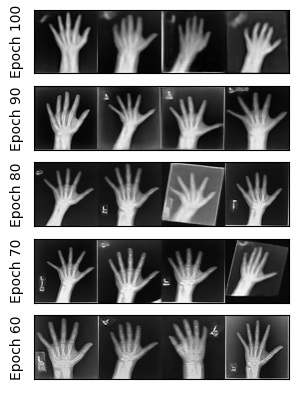

In [13]:
# Plot last 5 evaluations
val_samples = np.linspace(n_epochs, val_interval, int(n_epochs / val_interval))
fig, ax = plt.subplots(nrows=5, ncols=1, sharey=True)
for image_n in range(5):
    reconstructions = torch.reshape(intermediary_images[image_n], (image_size * num_example_images, image_size)).T
    ax[image_n].imshow(reconstructions.cpu(), cmap="gray")
    ax[image_n].set_xticks([])
    ax[image_n].set_yticks([])
    ax[image_n].set_ylabel(f"Epoch {val_samples[image_n]:.0f}")

## Diffusion Model

### Define diffusion model and scheduler

In this section, we will define the diffusion model that will learn data distribution of the latent representation of the autoencoder. Together with the diffusion model, we define a beta scheduler responsible for defining the amount of noise tahat is added across the diffusion's model Markov chain.

In [14]:
unet = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=3,
    num_res_blocks=2,
    num_channels=(128, 256, 512),
    attention_levels=(False, True, True),
    num_head_channels=(0, 256, 512),
)

scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="linear_beta", beta_start=0.0015, beta_end=0.0195)

### Scaling factor

As mentioned in Rombach et al. [1] Section 4.3.2 and D.1, the signal-to-noise ratio (induced by the scale of the latent space) can affect the results obtained with the LDM, if the standard deviation of the latent space distribution drifts too much from that of a Gaussian. For this reason, it is best practice to use a scaling factor to adapt this standard deviation.

_Note: In case where the latent space is close to a Gaussian distribution, the scaling factor will be close to one, and the results will not differ from those obtained when it is not used._


In [15]:
with torch.no_grad():
    with autocast(enabled=True):
        z = autoencoderkl.encode_stage_2_inputs(check_data["image"].to(device))

print(f"Scaling factor set to {1/torch.std(z)}")
scale_factor = 1 / torch.std(z)

Scaling factor set to tensor(0.8888, device='cuda:0')


We define the inferer using the scale factor:

In [16]:
inferer = LatentDiffusionInferer(scheduler, scale_factor=scale_factor)

### Train diffusion model

It takes about ~80 min to train the model.

Epoch 39: 100%|█████████| 125/125 [00:16<00:00,  7.50it/s, loss=0.117]


Epoch 39 val loss: 0.1206


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 67.90it/s]


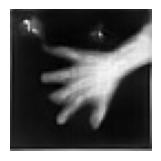

Epoch 79: 100%|█████████| 125/125 [00:16<00:00,  7.54it/s, loss=0.111]


Epoch 79 val loss: 0.1165


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 68.62it/s]


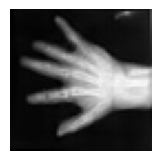

Epoch 119: 100%|████████| 125/125 [00:16<00:00,  7.56it/s, loss=0.112]


Epoch 119 val loss: 0.1217


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 68.20it/s]


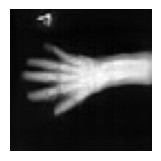

Epoch 159: 100%|████████| 125/125 [00:16<00:00,  7.50it/s, loss=0.104]


Epoch 159 val loss: 0.1100


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.06it/s]


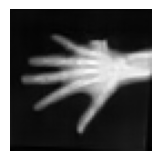

Epoch 199: 100%|████████| 125/125 [00:16<00:00,  7.53it/s, loss=0.104]


Epoch 199 val loss: 0.1028


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 68.91it/s]


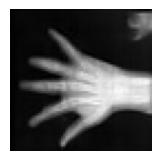

In [17]:
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)

unet = unet.to(device)
n_epochs = 200
val_interval = 40
epoch_losses = []
val_losses = []
scaler = GradScaler()

for epoch in range(n_epochs):
    unet.train()
    autoencoderkl.eval()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=True):
            z_mu, z_sigma = autoencoderkl.encode(images)
            z = autoencoderkl.sampling(z_mu, z_sigma)
            noise = torch.randn_like(z).to(device)
            timesteps = torch.randint(0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device).long()
            noise_pred = inferer(
                inputs=images, diffusion_model=unet, noise=noise, timesteps=timesteps, autoencoder_model=autoencoderkl
            )
            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_losses.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        unet.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)

                with autocast(enabled=True):
                    z_mu, z_sigma = autoencoderkl.encode(images)
                    z = autoencoderkl.sampling(z_mu, z_sigma)

                    noise = torch.randn_like(z).to(device)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device
                    ).long()
                    noise_pred = inferer(
                        inputs=images,
                        diffusion_model=unet,
                        noise=noise,
                        timesteps=timesteps,
                        autoencoder_model=autoencoderkl,
                    )

                    loss = F.mse_loss(noise_pred.float(), noise.float())

                val_loss += loss.item()
        val_loss /= val_step
        val_losses.append(val_loss)
        print(f"Epoch {epoch} val loss: {val_loss:.4f}")

        # Sampling image during training
        z = torch.randn((1, 3, 16, 16))
        z = z.to(device)
        scheduler.set_timesteps(num_inference_steps=1000)
        with autocast(enabled=True):
            decoded = inferer.sample(
                input_noise=z, diffusion_model=unet, scheduler=scheduler, autoencoder_model=autoencoderkl
            )

        plt.figure(figsize=(2, 2))
        plt.style.use("default")
        plt.imshow(decoded[0, 0].detach().cpu(), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()
progress_bar.close()


### Plot learning curves

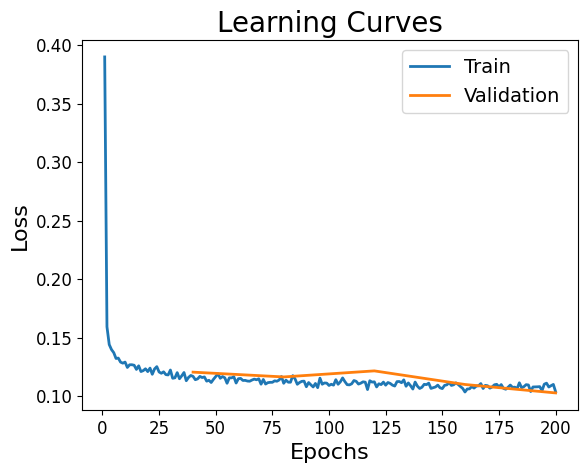

In [20]:
plt.figure()
plt.title("Learning Curves", fontsize=20)
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_losses, linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)), val_losses, linewidth=2.0, label="Validation"
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})

### Plotting sampling example

Finally, we generate an image with our LDM. For that, we will initialize a latent representation with just noise. Then, we will use the `unet` to perform 1000 denoising steps. For every 100 steps, we store the noisy intermediary samples. In the last step, we decode all latent representations and plot how the image looks like across the sampling process.

In [30]:
unet.eval()
scheduler.set_timesteps(num_inference_steps=1000)
noise = torch.randn((1, 3, 16, 16))
noise = noise.to(device)

with torch.no_grad():
    image, intermediates = inferer.sample(
        input_noise=noise,
        diffusion_model=unet,
        scheduler=scheduler,
        save_intermediates=True,
        intermediate_steps=100,
        autoencoder_model=autoencoderkl,
    )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 76.31it/s]


(-0.5, 639.5, 63.5, -0.5)

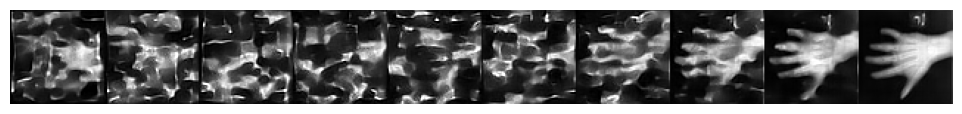

In [31]:
# Decode latent representation of the intermediary images
decoded_images = []
for image in intermediates:
    with torch.no_grad():
        decoded_images.append(image)
plt.figure(figsize=(10, 12))
chain = torch.cat(decoded_images, dim=-1)
plt.style.use("default")
plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")

### Clean-up data directory

In [22]:
if directory is None:
    shutil.rmtree(root_dir)